## GEMS

In [1]:
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
import pandas as pd
from pathlib import Path

redownload = False

fp = '../data/nexsci_data.csv'
if redownload or not Path(fp).exists():
    #pstable combines data from the Confirmed Planets and Extended Planet Parameters tables
    tab = NasaExoplanetArchive.query_criteria(table="pscomppars", 
    #                                          where="discoverymethod like 'Transit'"
    )
    df = tab.to_pandas()                                        
    df.to_csv(fp, index=True)
    
else:
    df = pd.read_csv(fp, index_col=0)
    df.index.name = 'index'
df.head()

/var/folders/4s/07r41mpn76n_0fykwqyjgc840000gn/T/ipykernel_5582/1112017024.py:17: DtypeWarning: Columns (70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp, index_col=0)


,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,discoverymethod,disc_locale,...,sy_pmra,sy_pmraerr1,sy_pmraerr2,sy_pmrastr,x,y,z,htm20,sky_coord.ra,sky_coord.dec
index,,,,,,,,,,,,,,,,,,,,,
0,OGLE-2016-BLG-1227L b,b,OGLE-2016-BLG-1227L,NaN,NaN,NaN,2020-03,2020,Microlensing,Ground,...,NaN,NaN,NaN,NaN,-0.063824,-0.828921,-0.555712,-768415656,265.597125,-33.759778
1,Kepler-276 c,c,Kepler-276,NaN,NaN,TIC 138213510,2014-02,2013,Transit,Space,...,7.99553,0.051581,-0.051581,7.9955300&plusmn;0.0515805,0.310575,-0.711954,0.629813,1302657699,293.568197,39.036312
2,Kepler-829 b,b,Kepler-829,NaN,NaN,TIC 123451768,2016-05,2016,Transit,Space,...,7.93777,0.040833,-0.040833,7.9377700&plusmn;0.0408326,0.157566,-0.720680,0.675124,-792260935,282.332831,42.463813
3,K2-283 b,b,K2-283,NaN,NaN,TIC 266017624,2018-12,2018,Transit,Space,...,-10.97340,0.053624,-0.053624,-10.9734000&plusmn;0.0536244,0.959702,0.224997,0.168368,609813555,13.194368,9.692918
4,Kepler-477 b,b,Kepler-477,NaN,NaN,TIC 158633329,2016-05,2016,Transit,Space,...,-26.00000,NaN,NaN,-26.0,0.229185,-0.702544,0.673726,-1968935374,288.067445,42.355305


In [25]:
mask_transit = df.discoverymethod.apply(lambda x: str.lower(x))=='transit'
mask_rv = df.discoverymethod.apply(lambda x: str.lower(x))=='radial velocity'
mask_Rp = df.pl_radj>0.4
mask_met = (df.st_met>=-1) & (df.st_met<=1)
mask_aRs = (df.pl_ratdor < 20)
idx_fgk = (df.st_teff>4000) & (df.st_teff<10000) & mask_Rp & mask_transit & mask_met & mask_aRs
idx_m = (df.st_teff<4000) & mask_Rp & mask_transit & mask_met & mask_aRs

param_names_planet = ['pl_name','pl_radj','pl_bmassj','pl_bmasse','pl_orbper']
param_names_star = ['st_rad','st_mass','st_teff','st_met','st_logg']

hj = df[idx_fgk][param_names_planet+param_names_star].reset_index(drop=True)
gems = df[idx_m][param_names_planet+param_names_star].reset_index(drop=True)
hj.shape, gems.shape

((579, 10), (19, 10))

In [26]:
hj['type'] = 'HJ'
gems['type'] = 'GEMS'
d = pd.concat([hj,gems]).reset_index(drop=True)
d.head()

,pl_name,pl_radj,pl_bmassj,pl_bmasse,pl_orbper,st_rad,st_mass,st_teff,st_met,st_logg,type
0,WASP-70 A b,1.164,0.590,187.5120,3.713020,1.22,1.11,5763.0,-0.006,4.31,HJ
1,HAT-P-18 b,0.995,0.197,62.6100,5.508023,0.75,0.77,4803.0,0.100,4.57,HJ
2,XO-4 b,1.250,1.420,451.3186,4.125080,1.45,1.10,6397.0,-0.040,4.18,HJ
3,K2-107 b,1.426,0.840,266.9772,3.313959,1.81,1.30,6061.0,0.140,4.04,HJ
4,WASP-13 b,1.220,0.360,114.4188,4.353010,1.37,0.72,5950.0,0.000,4.06,HJ


In [32]:
pl.style.use("default")

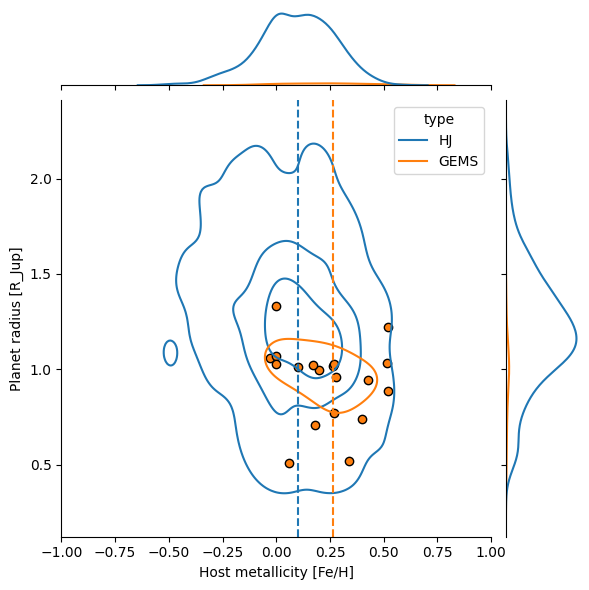

In [33]:
import seaborn as sb

x,y = "st_met", "pl_radj"
g = sb.jointplot(
    data=d,
    x=x, 
    y=y, 
    hue='type',
    kind="kde",
    # kind="scatter",
    # marginal_ticks=True,
    levels=4,
    xlim=(-1,1),
)
g.ax_joint.scatter(gems[x], gems[y], marker='o', edgecolors="k", c="C1")
# g.map(sb.regplot, color=".3")
g.ax_joint.set_xlabel("Host metallicity [Fe/H]")
g.ax_joint.set_ylabel("Planet radius [R_Jup]")
g.ax_joint.axvline(gems[x].median(), 0, 1, c="C1", ls="--")
g.ax_joint.axvline(hj[x].median(), 0, 1, c="C0", ls="--")

## Does this trend hold for any Mp/Ms?

In [34]:
import astropy.units as u

def get_mass_ratio(mp, ms):
    return 100*(mp*u.Mjup.to(u.Msun)/ms)

In [35]:
hj['mp/ms'] = hj.apply(lambda x: get_mass_ratio(x.pl_bmassj, x.st_mass), axis=1)
gems['mp/ms'] = gems.apply(lambda x: get_mass_ratio(x.pl_bmassj, x.st_mass), axis=1)
d = pd.concat([hj,gems]).reset_index(drop=True)
d.head()

,pl_name,pl_radj,pl_bmassj,pl_bmasse,pl_orbper,...,st_teff,st_met,st_logg,type,mp/ms
0,WASP-70 A b,1.164,0.590,187.5120,3.713020,...,5763.0,-0.006,4.31,HJ,0.050740
1,HAT-P-18 b,0.995,0.197,62.6100,5.508023,...,4803.0,0.100,4.57,HJ,0.024423
2,XO-4 b,1.250,1.420,451.3186,4.125080,...,6397.0,-0.040,4.18,HJ,0.123229
3,K2-107 b,1.426,0.840,266.9772,3.313959,...,6061.0,0.140,4.04,HJ,0.061681
4,WASP-13 b,1.220,0.360,114.4188,4.353010,...,5950.0,0.000,4.06,HJ,0.047730


## Does this trend hold for any spec type or only M dwarfs?

In [52]:
from astropy.table import Table
import numpy as np

url = "https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt"
table = Table.read(url,
                   format='ascii',
                   comment='',
                   header_start=22,
                   data_start=23,
                   data_end=141,
                   delimiter=' ',
                   fill_values=('...', np.nan),
                   fast_reader=False,
                   guess=False
                  )
tab = table.to_pandas()
tab.head()

,#SpT,Teff,logT,BCv,logL,Mbol,R_Rsun,Mv,B-V,Bt-Vt,...,M_Ks,Ks-W1,W1-W2,W1-W3,W1-W4,g-r,i-z,z-Y,Msun,#SpT_1
0,O3V,44900,4.652,-4.01,5.82,-9.81,13.43,-5.80,-0.330,NaN,...,....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,O3V
1,O4V,42900,4.632,-3.89,5.65,-9.39,12.13,-5.50,-0.326,NaN,...,....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,O4V
2,O5V,41400,4.617,-3.76,5.54,-9.11,11.45,-5.35,-0.323,NaN,...,....,NaN,NaN,NaN,NaN,-0.62,NaN,NaN,43.0,O5V
3,O5.5V,40500,4.607,-3.67,5.44,-8.87,10.71,-5.20,-0.322,NaN,...,....,NaN,NaN,NaN,NaN,-0.62,NaN,NaN,38.0,O5.5V
4,O6V,39500,4.597,-3.57,5.36,-8.67,10.27,-5.10,-0.321,NaN,...,....,NaN,NaN,NaN,NaN,-0.62,NaN,NaN,35.0,O6V


In [37]:
#replace duplicated column=SpT_1 with letter only
tab['SpT_1'] = tab['#SpT'].apply(lambda x: x[0])

#compute the mean Teff per spec type
type_teff_mean = {}
type_teff_range = {}
for type, group, in tab.groupby(by='SpT_1', sort=False):
    mean_teff = group.Teff.mean()
    print(f"{type}: {mean_teff:,.0f}")
    type_teff_mean[type] = int(mean_teff)
    type_teff_range[type] = (int(group.Teff.min()), int(group.Teff.max()))

O: 37,942
B: 18,643
A: 8,341
F: 6,535
G: 5,663
K: 4,573
M: 3,076
L: 1,786
T: 956
Y: 351


In [38]:
cat = dict(sorted(type_teff_range.items(), key=lambda item: item[1]))

# Create bins from the dictionary values
bins = [b[0] for b in cat.values()] + [cat['O'][1]] 

# Create labels from the dictionary keys
labels = list(cat.keys())

# Add a new column with the categories
df['spec_type'] = pd.cut(df['st_teff'], bins=bins, labels=labels)
df.tail()

,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,discoverymethod,disc_locale,...,sy_pmraerr1,sy_pmraerr2,sy_pmrastr,x,y,z,htm20,sky_coord.ra,sky_coord.dec,spec_type
index,,,,,,,,,,,,,,,,,,,,,
5597,HD 222155 b,b,HD 222155,HD 222155,HIP 116616,TIC 26370518,2012-09,2011,Radial Velocity,Ground,...,0.044574,-0.044574,195.3000000&plusmn;0.0445736,0.653094,-0.062856,0.754664,-1429038531,354.502562,48.996019,G
5598,HD 88986 b,b,HD 88986,HD 88986,HIP 50316,TIC 1042868,2023-11,2023,Radial Velocity,Ground,...,0.086999,-0.086999,-65.6924000&plusmn;0.0869986,-0.789290,0.382975,0.479949,-2408646,154.116687,28.682071,G
5599,Kepler-30 b,b,Kepler-30,NaN,NaN,TIC 399794329,2012-07,2012,Transit,Space,...,0.055243,-0.055243,0.6950830&plusmn;0.0552427,0.205007,-0.750219,0.628605,292778943,285.283648,38.947263,G
5600,HD 3167 d,d,HD 3167,HD 3167,HIP 2736,TIC 318707987,2017-09,2017,Radial Velocity,Ground,...,0.127388,-0.127388,107.409000&plusmn;0.127388,0.985500,0.151510,0.076384,-1000385905,8.740149,4.380721,K
5601,OGLE-2019-BLG-1180L b,b,OGLE-2019-BLG-1180L,NaN,NaN,NaN,2023-12,2023,Microlensing,Ground,...,NaN,NaN,NaN,-0.011613,-0.883072,-0.469093,1119103151,269.246542,-27.975444,NaN


/opt/miniconda3/envs/toi5671/lib/python3.11/site-packages/seaborn/axisgrid.py:1889: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


(-0.5, 2.0)

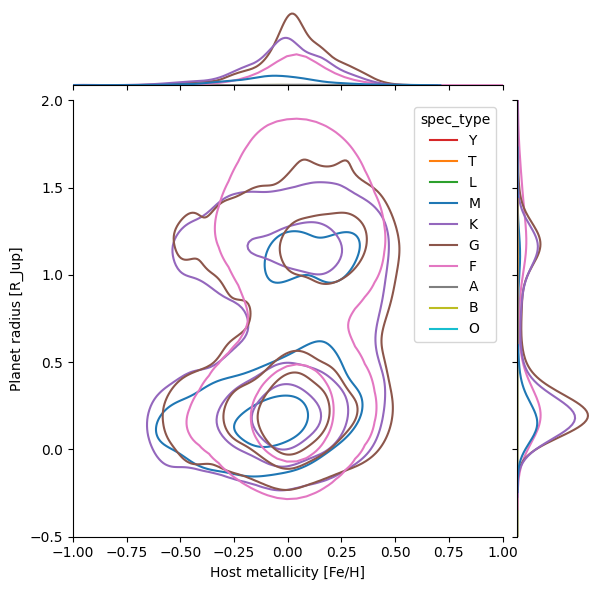

In [51]:
import seaborn as sb

x,y = "st_met", "pl_radj"
g = sb.jointplot(
    data=df,
    x=x, 
    y=y, 
    hue='spec_type',
    kind="kde",
    # kind="scatter",
    # marginal_ticks=True,
    levels=4,
    xlim=(-1,1),
)
# g.ax_joint.scatter(gems[x], gems[y], marker='o', edgecolors="k", c="C1")
g.ax_joint.set_xlabel("Host metallicity [Fe/H]")
g.ax_joint.set_ylabel("Planet radius [R_Jup]")
# g.ax_joint.axvline(gems[x].median(), 0, 1, c="C1", ls="--")
# g.ax_joint.axvline(hj[x].median(), 0, 1, c="C0", ls="--")
g.ax_joint.set_ylim(-0.5,2)

In [39]:
#small transiting planet
df1 = df[(df.pl_radj<0.5) & mask_transit & mask_met]
df1['mp/ms'] = df1.apply(lambda x: get_mass_ratio(x.pl_bmassj, x.st_mass), axis=1)
df1.groupby(by='spec_type')['st_met'].mean()

/var/folders/4s/07r41mpn76n_0fykwqyjgc840000gn/T/ipykernel_5582/4068490343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mp/ms'] = df1.apply(lambda x: get_mass_ratio(x.pl_bmassj, x.st_mass), axis=1)
/var/folders/4s/07r41mpn76n_0fykwqyjgc840000gn/T/ipykernel_5582/4068490343.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby(by='spec_type')['st_met'].mean()


spec_type
Y         NaN
T         NaN
L         NaN
M   -0.084538
K   -0.028005
G    0.014546
F    0.009887
A   -0.102500
B         NaN
O         NaN
Name: st_met, dtype: float64

In [40]:
df1.groupby(by='spec_type')['mp/ms'].mean()

/var/folders/4s/07r41mpn76n_0fykwqyjgc840000gn/T/ipykernel_5582/4113758905.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby(by='spec_type')['mp/ms'].mean()


spec_type
Y         NaN
T         NaN
L         NaN
M    0.009190
K    0.003727
G    0.022642
F    0.003569
A    0.003522
B         NaN
O         NaN
Name: mp/ms, dtype: float64

## where does the Rp transition occur?

In [ ]:
#giant transiting planet
mean_mets = {}
mean_mets_counts = {}
mean_mass_ratios = {}
mean_mass_ratios_counts = {}

N = 20
Rps = np.linspace(0.1, 2, N)
for i,Rp in enumerate(Rps):
    #set max radius within bin
    # mask = df.pl_radj<=Rp
    # set min radius within bin
    mask = df.pl_radj>=Rp
    
    # radius bin
    # if i<N-1:
    #     mask = (df.pl_radj>=Rp) & df.pl_radj<Rps[i+1]
    # else:
    #     mask = (df.pl_radj>=Rp)
    df2 = df[mask & mask_transit & mask_met]
    df2['mp/ms'] = df2.apply(lambda x: get_mass_ratio(x.pl_bmassj, x.st_mass), axis=1)
    mean_met = df2.groupby(by='spec_type')['st_met'].mean().dropna(how="all")
    mean_met_count = df2.groupby(by='spec_type')['st_met'].count()
    mean_mass_ratio = df2.groupby(by='spec_type')['mp/ms'].mean().dropna(how="all")
    mean_mass_ratio_count = df2.groupby(by='spec_type')['mp/ms'].count()

    # key = f'r={Rp:.1f}'
    key = round(Rp, 1)
    mean_mets[key] = mean_met
    mean_mets_counts[key] = mean_met_count
    mean_mass_ratios[key] = mean_mass_ratio
    mean_mass_ratios_counts[key] = mean_mass_ratio_count

In [42]:
d1 = pd.DataFrame(mean_mets)
d1c = pd.DataFrame(mean_mets_counts).replace(0, np.nan).dropna(how="all")
d1

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0
spec_type,,,,,,,,,,,,,,,,,,,,
M,-0.039523,0.065197,0.161029,0.168069,0.227400,0.232714,0.238050,0.230059,0.200867,0.175667,0.276667,0.260000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K,-0.003921,0.025885,0.103689,0.115572,0.123573,0.118608,0.122182,0.125658,0.116146,0.111426,0.082775,0.086765,0.085769,0.098333,0.176667,0.140000,0.140000,0.180000,0.180,0.180
G,0.032886,0.048685,0.087470,0.101934,0.106644,0.109810,0.113365,0.112381,0.108591,0.101107,0.104287,0.102000,0.065333,0.075321,0.173714,0.180900,0.174600,0.228000,0.176,0.176
F,0.021109,0.028311,0.037864,0.040404,0.041421,0.045854,0.046029,0.048076,0.048796,0.046867,0.038199,0.032916,0.022396,0.025689,0.025677,-0.003974,-0.015526,-0.057273,-0.080,0.020
A,-0.013737,0.013833,0.011706,0.009933,0.009933,0.009933,0.009933,0.009933,0.009933,0.009933,0.009933,0.009933,0.011357,0.009077,0.002333,0.000167,-0.057800,0.000250,-0.120,NaN


In [43]:
d1c

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0
spec_type,,,,,,,,,,,,,,,,,,,,
M,216.0,76.0,34.0,29.0,25.0,21.0,20.0,17.0,15.0,12.0,3.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K,1145.0,619.0,254.0,187.0,157.0,143.0,132.0,120.0,103.0,68.0,40.0,17.0,13.0,6.0,3.0,2.0,2.0,1.0,1.0,1.0
G,1576.0,989.0,481.0,363.0,326.0,300.0,282.0,260.0,237.0,215.0,164.0,108.0,57.0,28.0,14.0,10.0,5.0,2.0,1.0,1.0
F,818.0,546.0,346.0,287.0,266.0,254.0,243.0,237.0,226.0,218.0,186.0,166.0,134.0,103.0,65.0,38.0,19.0,11.0,7.0,3.0
A,19.0,18.0,17.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,14.0,13.0,12.0,6.0,5.0,4.0,1.0,NaN


Text(0.5, 1.0, 'Host star metallicity of small and giant planets')

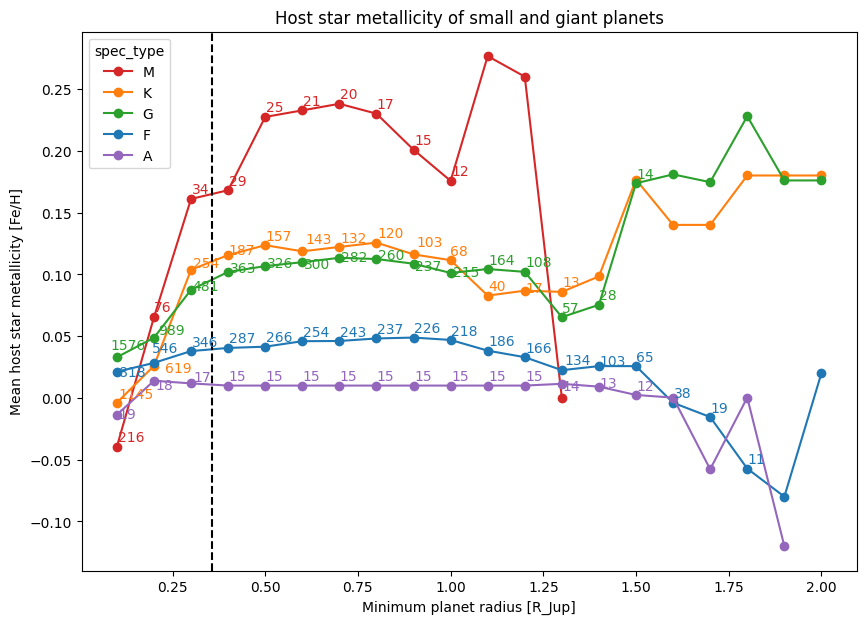

In [44]:
import matplotlib.pyplot as pl
from adjustText import adjust_text
# cmap = pl.get_cmap("rainbow_r")
# colors = cmap(np.linspace(0,1,5))
from cycler import cycler
pl.rcParams['axes.prop_cycle'] = cycler('color', ['#d62728', 
                                                  '#ff7f0e', 
                                                  '#2ca02c', 
                                                  '#1f77b4',                                                   
                                                  '#9467bd', 
                                                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

fig, ax = pl.subplots(figsize=(10,7))
ax = d1.T.plot(marker='o', #cmap=cmap, 
               ax=ax)
txts = []
rows,cols = d1.shape
for col in range(cols):
    for row in range(rows):
        xx = d1.iloc[row].index[col]
        yy = d1.iloc[row, col]
        count = d1c.iloc[row, col]
        if count>10:
            t = ax.annotate(f'{int(count)}', xy=(xx, yy), c=f"C{row}") 
            # t = ax.annotate(f'{int(count)}', xy=(xx, yy), c=colors[row]) 
            txts.append(t)
adjust_text(txts)
ax.axvline(4*u.Rearth.to(u.Rjup), 0, 1, ls='--', c='k')
# ax.axvline(9*u.Rearth.to(u.Rjup), 0, 1, ls='--', c='k')
ax.set_ylabel('Mean host star metallicity [Fe/H]')
ax.set_xlabel('Minimum planet radius [R_Jup]');
# ax.set_xlim(0,1.1)
ax.set_title("Host star metallicity of small and giant planets")

In [45]:
from aesthetic.plot import savefig

savefig(fig, "../figures/met_per_spec_HJ.png", writepdf=False)

2024-04-15T06:51:44.385844: made ../figures/met_per_spec_HJ.png


In [19]:
d2 = pd.DataFrame(mean_mass_ratios)
d2c = pd.DataFrame(mean_mass_ratios_counts).replace(0, np.nan).dropna(how="all")
d2

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0
spec_type,,,,,,,,,,,,,,,,,,,,
M,0.034756,0.081996,0.168247,0.195017,0.224136,0.262948,0.274981,0.315077,0.347076,0.417212,0.204374,0.256559,0.125021,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K,0.020673,0.036276,0.083290,0.108027,0.127280,0.138617,0.146966,0.158790,0.155408,0.182446,0.176057,0.141410,0.130861,0.151844,0.165753,0.221076,0.221076,0.393219,0.393219,0.393219
G,0.077710,0.123531,0.251672,0.264830,0.288827,0.313419,0.216226,0.233270,0.250866,0.225974,0.245150,0.291645,0.297707,0.479474,0.073300,0.081110,0.089353,0.114794,0.104298,0.104298
F,0.099825,0.149205,0.234243,0.280122,0.300562,0.314413,0.327618,0.334003,0.347971,0.356462,0.374848,0.381132,0.373758,0.292428,0.203250,0.289551,0.073541,0.079781,0.087695,0.116631
A,0.230365,0.243126,0.256829,0.290856,0.290856,0.290856,0.290856,0.290856,0.290856,0.290856,0.290856,0.290856,0.230616,0.195139,0.198338,0.174155,0.190270,0.191979,0.239827,NaN


## Mp/Ms seems like less sensitive to heterogeneous analysis

Text(0.5, 47.7222222222222, 'Minimum planet radius [R_Jup]')

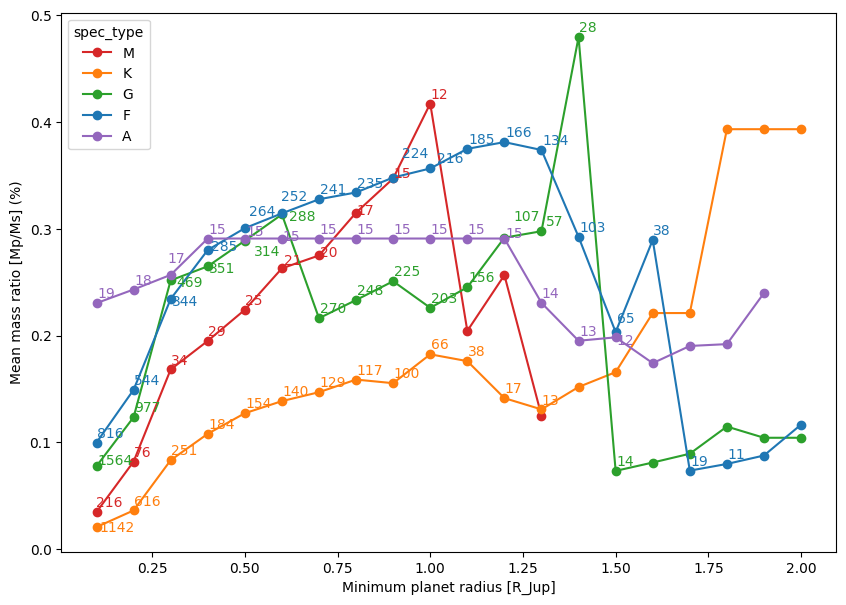

In [21]:
from adjustText import adjust_text
# cmap = pl.get_cmap("rainbow_r")
# colors = cmap(np.linspace(0,1,5))
from cycler import cycler
pl.rcParams['axes.prop_cycle'] = cycler('color', ['#d62728', 
                                                  '#ff7f0e', 
                                                  '#2ca02c', 
                                                  '#1f77b4',                                                   
                                                  '#9467bd', 
                                                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])



fig, ax = pl.subplots(figsize=(10,7))
ax = d2.T.plot(marker='o', ax=ax, #cmap=cmap
              )
txts = []
rows,cols = d2.shape
for col in range(cols):
    for row in range(rows):
        xx = d2.iloc[row].index[col]
        yy = d2.iloc[row, col]
        count = d2c.iloc[row, col]
        if count>10:
            t = ax.annotate(f'{int(count)}', xy=(xx, yy), c=f"C{row}") 
            # t = ax.annotate(f'{int(count)}', xy=(xx, yy), c=colors[row]) 
            txts.append(t)
adjust_text(txts)
ax.set_ylabel('Mean mass ratio [Mp/Ms] (%)')
ax.set_xlabel('Minimum planet radius [R_Jup]')

In [23]:
idx = df.spec_type.isin(['B','A','F','G','K','M'])
df[idx].spec_type.unique()

['G', 'K', 'F', 'M', 'A', 'B']
Categories (10, object): ['Y' < 'T' < 'L' < 'M' ... 'F' < 'A' < 'B' < 'O']

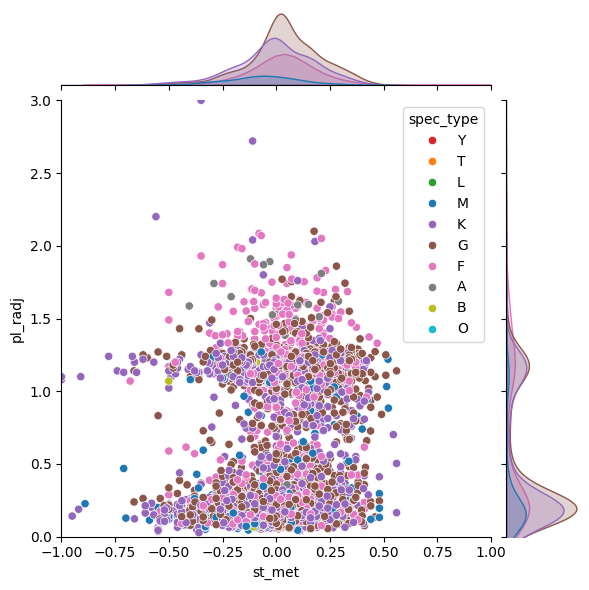

In [24]:
x,y = "st_met", "pl_radj"
g = sb.jointplot(
    data=df[idx],
    x=x, 
    y=y, 
    hue='spec_type',
    kind="scatter",
    xlim=(-1,1),
    ylim=(0,3),
)

In [1]:
import json
from urllib.request import urlopen

def get_exofop_json(target_name):
    url = f"https://exofop.ipac.caltech.edu/tess/target.php?id={target_name}&json"
    print(f"Querying data from exofop:\n{url}")
    response = urlopen(url)
    data_json = json.loads(response.read())
    return data_json
    
target_name = "TOI 5671"
data_json = get_exofop_json(target_name.replace(' ', '-'))
tic_params = data_json['stellar_parameters'][1]

Querying data from exofop:
https://exofop.ipac.caltech.edu/tess/target.php?id=TOI-5671&json


In [2]:
Rs = float(tic_params['srad'])
Ms = float(tic_params['mass'])
teff = float(tic_params['teff'])
logg = float(tic_params['logg'])
Rs, Ms, teff, logg

(0.408427, 0.400962, 3380.0, 4.81894)

In [3]:
planet_params = data_json['planet_parameters'][1]
period = float(planet_params['per']) 
t0 = float(planet_params['epoch'])
t14 = float(planet_params['dur'])
period, t0, t14

(3.3079817, 2459685.753346, 1.666)

In [4]:
import astropy.units as u

from astropy.units import Quantity
from astropy.constants import G
from numpy import pi, sin, sqrt

def mp_from_kiepms(k, i, e, p, mstar):
    """Calculates the planet's mass from RV parameters.

    Parameters
    ----------
    k: float, ndarray, or Quantity
        RV semiamplitude [m/s]
    i: float, ndarray, or Quantity
        Inclination [rad]
    e: float, ndarray, or Quantity
        Eccentricity [-]
    p: float, ndarray, or Quantity
        Orbital period [d]
    mstar: float, ndarray, or Quantity
        Stellar mass [Solar mass]

    Returns
    -------
    Planet mass [M_Jup]
    """
    k = k.to(u.m/u.s) if isinstance(k, Quantity) else k * u.m/u.s
    i = i.to(u.rad) if isinstance(i, Quantity) else i*u.rad
    p = p.to(u.s) if isinstance(p, Quantity) else (p*u.day).to(u.s)
    mstar = mstar.to(u.kg) if isinstance(mstar, Quantity) else (mstar*u.M_sun).to(u.kg)
    return (k * (p/(2*pi*G)) ** (1/3) * mstar ** (2 / 3) / sin(i) * sqrt((1 - e ** 2))).to(u.M_jup).value

k_rv = 245# m/s
inc = pi/2
ecc = 0
mass = mp_from_kiepms(k_rv, inc, ecc, period, Ms)
radius = float(planet_params['rad'])*u.Rearth.to(u.Rjup)
mass, radius

(0.9766625478769406, 1.068411150618251)

In [5]:
import astroquery
# assert astroquery.__version__=='0.4.5'

https://astroquery.readthedocs.io/en/latest/ipac/nexsci/nasa_exoplanet_archive.html

In [6]:
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
import pandas as pd
from pathlib import Path

redownload = False

fp = '../data/nexsci_data.csv'
if redownload or not Path(fp).exists():
    #pstable combines data from the Confirmed Planets and Extended Planet Parameters tables
    tab = NasaExoplanetArchive.query_criteria(table="pscomppars", 
    #                                          where="discoverymethod like 'Transit'"
    )
    df = tab.to_pandas()                                        
    df.to_csv(fp, index=True)
    
else:
    df = pd.read_csv(fp, index_col=0)
    df.index.name = 'index'
df.head()

/tmp/ipykernel_42391/1112017024.py:17: DtypeWarning: Columns (70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp, index_col=0)


,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,discoverymethod,disc_locale,...,sy_pmra,sy_pmraerr1,sy_pmraerr2,sy_pmrastr,x,y,z,htm20,sky_coord.ra,sky_coord.dec
index,,,,,,,,,,,,,,,,,,,,,
0,OGLE-2016-BLG-1227L b,b,OGLE-2016-BLG-1227L,NaN,NaN,NaN,2020-03,2020,Microlensing,Ground,...,NaN,NaN,NaN,NaN,-0.063824,-0.828921,-0.555712,-768415656,265.597125,-33.759778
1,Kepler-276 c,c,Kepler-276,NaN,NaN,TIC 138213510,2014-02,2013,Transit,Space,...,7.99553,0.051581,-0.051581,7.9955300&plusmn;0.0515805,0.310575,-0.711954,0.629813,1302657699,293.568197,39.036312
2,Kepler-829 b,b,Kepler-829,NaN,NaN,TIC 123451768,2016-05,2016,Transit,Space,...,7.93777,0.040833,-0.040833,7.9377700&plusmn;0.0408326,0.157566,-0.720680,0.675124,-792260935,282.332831,42.463813
3,K2-283 b,b,K2-283,NaN,NaN,TIC 266017624,2018-12,2018,Transit,Space,...,-10.97340,0.053624,-0.053624,-10.9734000&plusmn;0.0536244,0.959702,0.224997,0.168368,609813555,13.194368,9.692918
4,Kepler-477 b,b,Kepler-477,NaN,NaN,TIC 158633329,2016-05,2016,Transit,Space,...,-26.00000,NaN,NaN,-26.0,0.229185,-0.702544,0.673726,-1968935374,288.067445,42.355305


In [7]:
from uncertainties import ufloat, umath
from scipy.constants import G
import numpy as np

HALF_PI = 0.5 * np.pi
TWO_PI = 2.0 * np.pi
INV_PI = 1.0 / np.pi

D_H = 24.0
D_M = 60 * D_H
D_S = 60 * D_M

def equilibrium_temperature(tstar, a, f=0.25, ab=0):
    """Planetary equilibrium temperature [K].

    Parameters
    ----------
    tstar
        Effective stellar temperature  [K]
    a
        Scaled semi-major axis [Rsun]
    f
        Redistribution factor
    ab
        Bond albedo

    Returns
    -------
    Teq : float or ndarray
        Equilibrium temperature [K]
    """
    return tstar * umath.sqrt(1 / a) * (f * (1 - ab)) ** 0.25

def as_from_rhop(rho, period):
    """Scaled semi-major axis from the stellar density and planet's orbital period.

    Parameters
    ----------

      rho    : stellar density [g/cm^3]
      period : orbital period  [d]

    Returns
    -------

      as : scaled semi-major axis [R_star]
    """
    return (G/(3*np.pi))**(1/3) * ((period * D_S)**2 * 1e3 * rho)**(1 / 3)

def MR_relation(Rp):
  """Chen-Kipping M-R used in Kempton+2018
  """
  if Rp<1.23:
    return 0.9718*Rp**3.58
  elif 1.23<Rp<14.26:
    return 1.436*Rp**1.70
  else:
    return np.nan

def transmission_spectroscopy_metric(Rp, Teq, Mp, Rs, Jmag):
  """Kempton+2018
  """
  if Rp < 1.5:
    factor = 0.190
  elif 1.5 < Rp < 2.75:
    factor = 1.26
  elif 2.75 < Rp < 4.0:
    factor = 1.28
  elif 4.0 < Rp < 10.0:
    factor = 1.15
  else:
    factor = 1 #4
  return factor*(Rp**3*Teq)/(Mp*Rs**2)*10**(-Jmag/5)

In [8]:
df['Equilibrium Temperature (K)'] = df.pl_eqt.copy()

In [9]:
df['pl_masse_MR'] = df.pl_rade.apply(MR_relation)

In [10]:
cols = ['pl_rade', 'pl_eqt', 'pl_masse_MR', 'st_rad', 'sy_jmag']
df['TSM'] = df.apply(lambda x: transmission_spectroscopy_metric(x['pl_rade'],
                                                                      x['pl_eqt'],
                                                                      x['pl_masse_MR'],
                                                                      x['st_rad'],
                                                                      x['sy_jmag']),
                             axis=1
                             )

In [11]:
Rp = radius*u.Rjup.to(u.Rearth)
Teq = float(planet_params['eqt'])
Jmag = float(data_json['magnitudes'][8]['value'])
Mp = mass*u.Mjup.to(u.Mearth)
tsm = transmission_spectroscopy_metric(Rp, Teq, Mp, Rs, Jmag) #err0r becase 
tsm

41.12184590890915

In [14]:
Mp

310.41110137242333

In [13]:
Mp2 = 0.8*u.Mjup.to(u.Mearth)
Mp2

254.26272527573985

In [15]:
import numpy as np

toi5671b = {'pl_name': 'TOI-5671.01',
            'pl_orbper': period,
            'pl_rade': Rp,
            'pl_eqt': Teq,
            'pl_orbmax': period,
            'st_teff': teff,
            'st_mass': Ms,
            'st_rad': Rs,
            'sy_jmag': Jmag,
            'pl_masse_MR': Mp2,
            'TSM': 156.3,
            'ESM': np.nan,
           }
toi5671b = pd.DataFrame([toi5671b])
df = pd.concat([toi5671b, df], ignore_index=True)

https://www.astroexplorer.org/details/ajacf56df10

In [16]:
rv = df.query("discoverymethod=='Radial Velocity'")
transit = df.query("discoverymethod=='Transit'")
microlensing = df.query("discoverymethod=='Microlensing'")
imaging = df.query("discoverymethod=='Imaging'")
idx = (df.st_teff<=3500) & (df.pl_radj > 0.8)
rv2 = rv[idx]
microlensing2 = microlensing[idx]
imaging2 = imaging[idx]
transit2 = transit[idx]

/tmp/ipykernel_42391/2341308122.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rv2 = rv[idx]
/tmp/ipykernel_42391/2341308122.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  microlensing2 = microlensing[idx]
/tmp/ipykernel_42391/2341308122.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  imaging2 = imaging[idx]
/tmp/ipykernel_42391/2341308122.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  transit2 = transit[idx]


In [17]:
from astropy.coordinates import Distance

Distance(parallax=6.11*u.mas)

<Distance 163.66612111 pc>

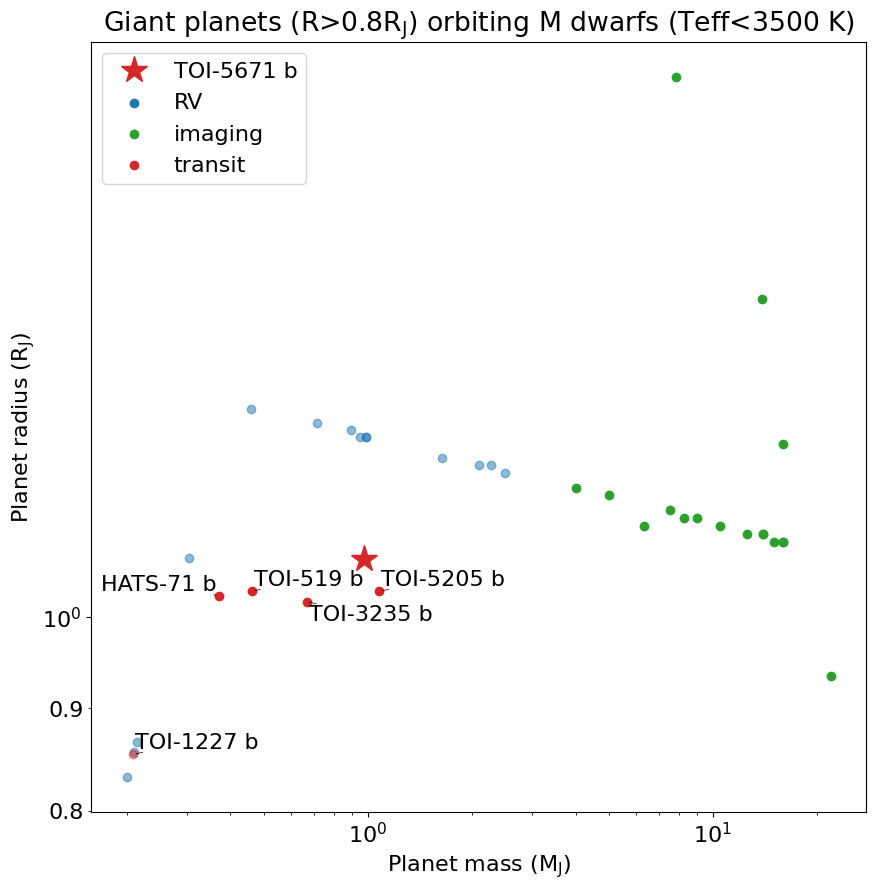

In [18]:
from adjustText import adjust_text
import matplotlib.pyplot as pl
from matplotlib.ticker import ScalarFormatter
pl.style.use("default")
pl.rcParams['font.size'] = 16

fig, ax = pl.subplots(figsize=(10,10))

x = 'pl_bmassj'
y = 'pl_radj'

c='C0'
idx_rv = rv2['pl_radj_reflink'].str.contains('CALCULATED')
ax.scatter(rv2[x][~idx_rv], rv2[y][~idx_rv], label='RV', c=c)
ax.scatter(rv2[x][idx_rv], rv2[y][idx_rv], c=c, alpha=0.5)

# ax.scatter(microlensing2[x], microlensing2[y], marker='o', label='microlensing', c='C1')
ax.scatter(imaging2[x], imaging2[y], label='imaging', c='C2')

c='C3'
idx_tr = transit2['pl_bmassj_reflink'].str.contains('CALCULATED')
ax.scatter(transit2[x][~idx_tr], transit2[y][~idx_tr], label='transit', c=c)
ax.scatter(transit2[x][idx_tr], transit2[y][idx_tr], c=c, alpha=0.5)
ax.plot(mass, radius, label='TOI-5671 b', ms=20, marker='*', ls='', c=c)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"Planet mass (M$_{\rm{J}}$)")
ax.set_ylabel(r"Planet radius (R$_{\rm{J}}$)")
ax.set_title(r"Giant planets (R>0.8R$_{\rm{J}}$) orbiting M dwarfs (Teff<3500 K)")

texts = []
# for i, row in rv2[~idx_rv].iterrows():
# for i, row in rv2.iterrows():
#     txt = pl.text(row[x], row[y], row['pl_name'])
#     texts.append(txt)
# for i, row in transit2[~idx_tr].iterrows():
for i, row in transit2.iterrows():
    txt = pl.text(row[x], row[y], row['pl_name'])
    texts.append(txt)
      
adjust_text(texts, 
            arrowprops=dict(arrowstyle="-", color='k', lw=0.5)
           );
# ax.xaxis.set_minor_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.legend(loc='best')
fig.savefig("mass_radius.png")

## mass ratio

In [21]:
0.8/(0.4*u.Msun.to(u.Mjup))

0.190918846793865

In [23]:
transit2['mass_ratio(%)']=transit2['pl_bmassj']/(transit2['st_mass']*u.Msun.to(u.Mjup))*100
transit2[['pl_name','mass_ratio(%)']].sort_values(by='mass_ratio(%)', ascending=False)

/tmp/ipykernel_42391/3497148672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transit2['mass_ratio(%)']=transit2['pl_bmassj']/(transit2['st_mass']*u.Msun.to(u.Mjup))*100


,pl_name,mass_ratio(%)
2488,TOI-5205 b,0.264349
781,TOI-3235 b,0.162771
2290,TOI-519 b,0.129993
3967,TOI-1227 b,0.117359
3259,HATS-71 b,0.072082


In [22]:
rv2['mass_ratio(%)']=rv2['pl_bmassj']/(rv2['st_mass']*u.Msun.to(u.Mjup))*100
rv2[['pl_name','mass_ratio(%)']].sort_values(by='mass_ratio(%)', ascending=False)

/tmp/ipykernel_42391/3670415533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rv2['mass_ratio(%)']=rv2['pl_bmassj']/(rv2['st_mass']*u.Msun.to(u.Mjup))*100


,pl_name,mass_ratio(%)
2034,GJ 876 b,0.678836
2308,GJ 317 b,0.568211
935,HIP 79431 b,0.409112
2309,GJ 317 c,0.373646
5321,GJ 3512 b,0.365928
2711,GJ 179 b,0.251907
4308,GJ 876 c,0.213054
1447,GJ 849 c,0.210011
2563,GJ 832 b,0.210011
1444,GJ 849 b,0.189434


In [58]:
transit2['mass_ratio(%)']=transit2['pl_bmassj']/(transit2['st_mass']*u.Msun.to(u.Mjup))*100
transit2[['pl_name','mass_ratio(%)','TSM']].sort_values(by='mass_ratio(%)',ascending=False)

/tmp/ipykernel_63803/1924356678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transit2['mass_ratio(%)']=transit2['pl_bmassj']/(transit2['st_mass']*u.Msun.to(u.Mjup))*100


,pl_name,mass_ratio(%),TSM
2488,TOI-5205 b,0.264349,336.340542
781,TOI-3235 b,0.162771,331.325878
2290,TOI-519 b,0.129993,253.150230
3967,TOI-1227 b,0.117359,49.141002
3259,HATS-71 b,0.072082,127.549652


In [48]:
mass/(Ms*u.Msun.to(u.Mjup))

0.00232519898827599

In [39]:
transit2['pl_bmassj_reflink'].apply(lambda x: x.split('href=')[1]).tolist()

['https://ui.adsabs.harvard.edu/abs/2023arXiv230210008H/abstract target=ref>Hobson et al. 2023</a>',
 'https://ui.adsabs.harvard.edu/abs/2023arXiv230414703K/abstract target=ref>Kagetani et al. 2023</a>',
 'https://ui.adsabs.harvard.edu/abs/2023AJ....165..120K/abstract target=ref>Kanodia et al. 2023</a>',
 'https://ui.adsabs.harvard.edu/abs/2020AJ....159..267B/abstract target=ref>Bakos et al. 2020</a>',
 '/docs/composite_calc.html target=_blank>Calculated Value</a>']

* [TOI-3235 b](https://ui.adsabs.harvard.edu/abs/2023ApJ...946L...4H/abstract)
* [TOI-519 b]()
* [TOI-5205 b](https://ui.adsabs.harvard.edu/abs/2023AJ....165..120K/abstract)
* [HATS-71 b](https://ui.adsabs.harvard.edu/abs/2020AJ....159..267B/abstract)
* [TOI-1227 b]()
* [Gan+2023](): A Massive Hot Jupiter Orbiting a Metal-rich Early M Star Discovered in the TESS Full-frame Images

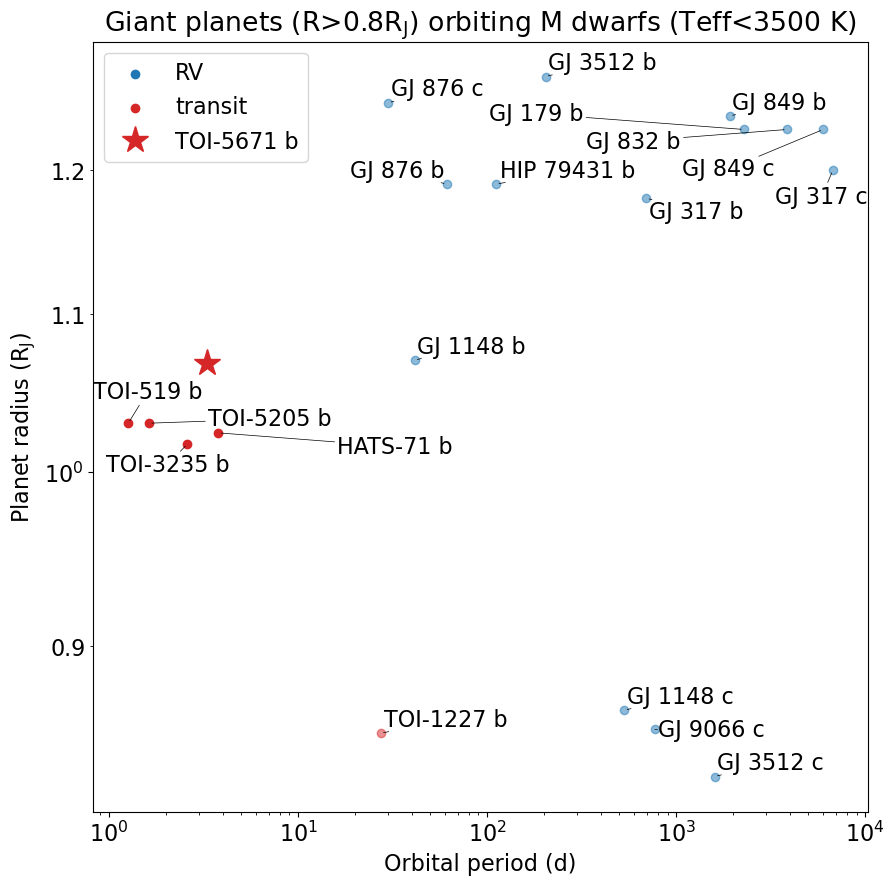

In [69]:
fig, ax = pl.subplots(figsize=(10,10))

x = 'pl_orbper'
y = 'pl_radj'

c='C0'
idx_rv = rv2['pl_radj_reflink'].str.contains('CALCULATED')
ax.scatter(rv2[x][~idx_rv], rv2[y][~idx_rv], label='RV', c=c)
ax.scatter(rv2[x][idx_rv], rv2[y][idx_rv], c=c, alpha=0.5)

# ax.scatter(microlensing2[x], microlensing2[y], marker='o', label='microlensing', c='C1')
# ax.scatter(imaging2[x], imaging2[y], label='imaging', c='C2')

c='C3'
idx_tr = transit2['pl_bmassj_reflink'].str.contains('CALCULATED')
ax.scatter(transit2[x][~idx_tr], transit2[y][~idx_tr], label='transit', c=c)
ax.scatter(transit2[x][idx_tr], transit2[y][idx_tr], c=c, alpha=0.5)
ax.plot(period, radius, label='TOI-5671 b', ms=20, marker='*', ls='', c=c)

ax.set_xlabel(r"Orbital period (d)")
ax.set_ylabel(r"Planet radius (R$_{\rm{J}}$)")
ax.set_title(r"Giant planets (R>0.8R$_{\rm{J}}$) orbiting M dwarfs (Teff<3500 K)")

texts = []
# for i, row in rv2[~idx_rv].iterrows():
for i, row in rv2.iterrows():
    txt = pl.text(row[x], row[y], row['pl_name'])
    texts.append(txt)
# for i, row in transit2[~idx_tr].iterrows():
for i, row in transit2.iterrows():
    txt = pl.text(row[x], row[y], row['pl_name'])
    texts.append(txt)

ax.set_xscale('log')
ax.set_yscale('log')

adjust_text(texts, 
            arrowprops=dict(arrowstyle="-", color='k', lw=0.5)
           );
# ax.xaxis.set_minor_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.legend(loc='best')

fig.savefig("period_radius.png")

## TSM
* https://colab.research.google.com/drive/1ThEKXYfVZBms5DvrzovCsOJwxL5uLiKW#scrollTo=tzwl4VCoWDeE

Text(0, 0.5, 'TSM')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

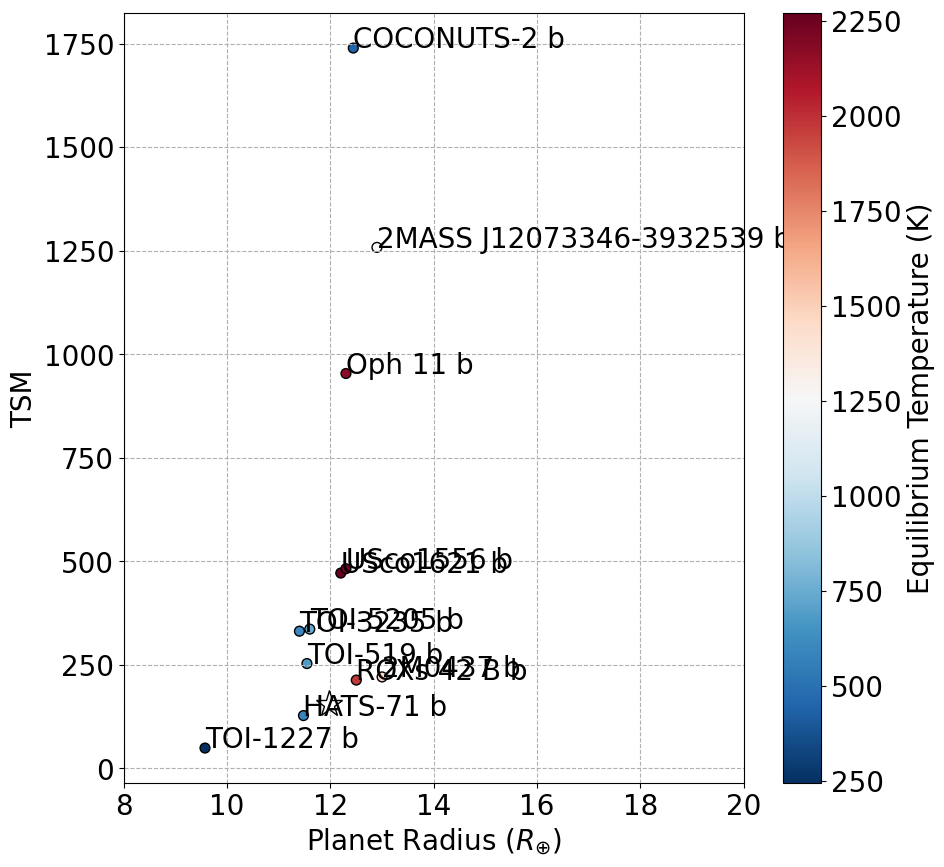

In [219]:
# from aesthetic.plot import savefig
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as pl
pl.style.use("default")
pl.rcParams['font.size'] = 20

fig, ax = pl.subplots(figsize=(10,10))

Rp_min, Rp_max = 8,  20

x="pl_rade"
y="TSM"
s = df[idx].plot(kind='scatter',
                     x=x, y=y,
                     c="Equilibrium Temperature (K)",
                     cmap="RdBu_r",
                     marker='o',
                     s=50,
                     edgecolors= "black",
                     ax=ax,
                     )

ax.grid(True, which='both', linestyle='--')
texts = []
for i, row in df[idx].iterrows():
  try:
    txt = ax.text(row[x], row[y], row['pl_name'])
    texts.append(txt)
  except:
    pass

ax.plot(toi5671b[x], toi5671b[y],
        'k*', ms=20, mfc="None", mew=1, label='_nolegend_')
# adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

ax.set_xlim(Rp_min, Rp_max)
ax.set_xlabel(r"Planet Radius ($R_{\oplus}$)")
ax.set_ylabel("TSM")
# ax.set_ylim(10, 30)
# ax.set_title("NExSci")
# ax.xaxis.set_minor_formatter(ScalarFormatter())
# ax.yaxis.set_minor_formatter(ScalarFormatter())
# savefig(fig, "nexsci.png", writepdf=False, dpi=450)

In [157]:
from uncertainties import ufloat

def upper_boundary(period, method='stripe'):
    if method=='stripe':
        return -0.33*period+1.17
    elif method=='likelihood':
        a=ufloat(0.31,0.12)
        b=ufloat(1.19,0.06)
        return -a*period+b
    
def lower_boundary(period, method='stripe'):
    if method=='stripe':
        return 0.68*period
    elif method=='likelihood':
        a=ufloat(0.67,0.06)
        b=ufloat(0.01,0.04)
        return a*period-b

## 1-column format

/home/jp/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


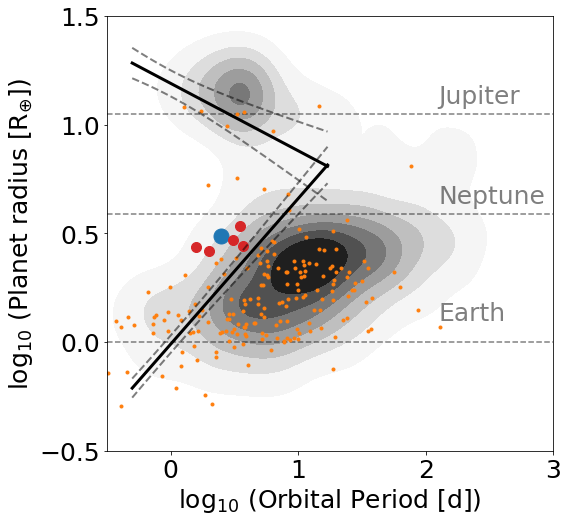

In [29]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as pl
pl.rcParams['font.size'] = 25


fig, ax = pl.subplots(figsize=(8,8))

xmin,xmax=np.log10(0.5), np.log10(17) #day
x=np.linspace(xmin,xmax)

method='likelihood'
y1=[i.n for i in upper_boundary(x,method=method)]
ys1=[i.s for i in upper_boundary(x,method=method)]

y2=[i.n for i in lower_boundary(x,method=method)]
ys2=[i.s for i in lower_boundary(x,method=method)]

#toi1696
Rp,per=3.09,2.5
ax.plot(np.log10(2.5), np.log10(3.09), 'o', c='C0', ms=15)#, label="TOI 1696b")
# ax.errorbar(np.log10(per), 
#             np.log10(Rp), 
#             yerr=np.c_[(np.log10(Rp-0.11),np.log10(Rp+0.11))].T, 
#             yerr=np.log10(0.11),
#             marker='o',
#             c='C0', 
#             ms=15, 
#             label="TOI 1696b")
# ax.legend()
#known planets
idx = df.st_teff<=3800 #around M dwarfs
ax.plot(np.log10(df.loc[idx,'pl_orbper']), 
        np.log10(df.loc[idx,'pl_rade']), 
        '.', 
        c='C1'
       )
#most similar planets
ax.plot(np.log10(df2.loc[idx,'pl_orbper']), 
        np.log10(df2.loc[idx,'pl_rade']), 
        'o', 
        ms=10,
        c='C3'
       )
#density contour
_ = sb.kdeplot(np.log10(df['pl_orbper']), 
               np.log10(df['pl_rade']), 
               cmap='gray_r', 
               n_levels=8, 
               log_scale=False, 
               fill=True, 
               ax=ax, 
               zorder=-1)

#upper boundary
ax.plot(x,y1,'k-',lw=3,zorder=10)
ax.plot(x,np.add(y1,ys1),'k--',lw=2,zorder=10,alpha=0.5)
ax.plot(x,np.subtract(y1,ys1),'k--',lw=2,zorder=10,alpha=0.5)
#lower boundary
ax.plot(x,y2,'k-',lw=3,zorder=10)
ax.plot(x,np.add(y2,ys2),'k--',lw=2,zorder=10,alpha=0.5)
ax.plot(x,np.subtract(y2,ys2),'k--',lw=2,zorder=10,alpha=0.5)


ax.set_xlabel("$\log_{10}$ (Orbital Period [d])")
ax.set_ylabel("$\log_{10}$ (Planet radius [R$_{\oplus}$])")

alpha = 0.5
ax.axhline(np.log10(1), 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
dx = 2.1
ax.text(dx, 0.1, 'Earth', alpha=alpha)
Rnep = np.log10(3.88)
ax.axhline(Rnep, 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
ax.text(dx, Rnep+0.05, 'Neptune', alpha=alpha)
Rjup = np.log10(11.2)
ax.axhline(Rjup, 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
ax.text(dx, Rjup+0.05, 'Jupiter', alpha=alpha)
ax.set_ylim(-0.5,1.5)
ax.set_xlim(-0.5,3)

ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=4)

## wide format

/home/jp/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


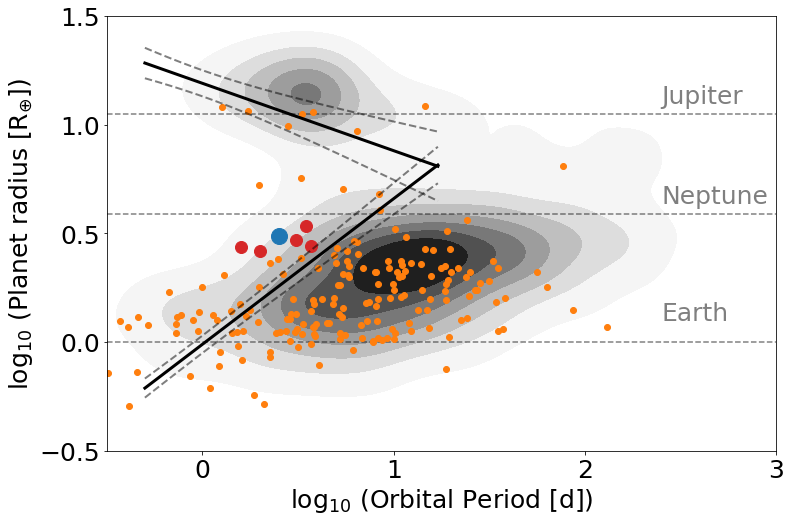

In [8]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as pl
pl.rcParams['font.size'] = 25


fig, ax = pl.subplots(figsize=(12,8))

xmin,xmax=np.log10(0.5), np.log10(17) #day
x=np.linspace(xmin,xmax)

method='likelihood'
y1=[i.n for i in upper_boundary(x,method=method)]
ys1=[i.s for i in upper_boundary(x,method=method)]

y2=[i.n for i in lower_boundary(x,method=method)]
ys2=[i.s for i in lower_boundary(x,method=method)]

#toi1696
Rp,per=3.09,2.5
ax.plot(np.log10(2.5), np.log10(3.09), 'o', c='C0', ms=16)#, label="TOI 1696b")
# ax.errorbar(np.log10(per), 
#             np.log10(Rp), 
#             yerr=np.c_[(np.log10(Rp-0.11),np.log10(Rp+0.11))].T, 
#             yerr=np.log10(0.11),
#             marker='o',
#             c='C0', 
#             ms=15, 
#             label="TOI 1696b")
# ax.legend()
#known planets
idx = df.st_teff<=3800 #around M dwarfs
ax.plot(np.log10(df.loc[idx,'pl_orbper']), 
        np.log10(df.loc[idx,'pl_rade']), 
        'o', 
        c='C1'
       )
#most similar planets
ax.plot(np.log10(df2.loc[idx,'pl_orbper']), 
        np.log10(df2.loc[idx,'pl_rade']), 
        'o', 
        ms=12,
        c='C3'
       )
#density contour
_ = sb.kdeplot(np.log10(df['pl_orbper']), 
               np.log10(df['pl_rade']), 
               cmap='gray_r', 
               n_levels=8, 
               log_scale=False, 
               fill=True, 
               ax=ax, 
               zorder=-1)

#upper boundary
ax.plot(x,y1,'k-',lw=3,zorder=10)
ax.plot(x,np.add(y1,ys1),'k--',lw=2,zorder=10,alpha=0.5)
ax.plot(x,np.subtract(y1,ys1),'k--',lw=2,zorder=10,alpha=0.5)
#lower boundary
ax.plot(x,y2,'k-',lw=3,zorder=10)
ax.plot(x,np.add(y2,ys2),'k--',lw=2,zorder=10,alpha=0.5)
ax.plot(x,np.subtract(y2,ys2),'k--',lw=2,zorder=10,alpha=0.5)


ax.set_xlabel("$\log_{10}$ (Orbital Period [d])")
ax.set_ylabel("$\log_{10}$ (Planet radius [R$_{\oplus}$])")

alpha = 0.5
ax.axhline(np.log10(1), 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
dx = 2.4
ax.text(dx, 0.1, 'Earth', alpha=alpha)
Rnep = np.log10(3.88)
ax.axhline(Rnep, 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
ax.text(dx, Rnep+0.05, 'Neptune', alpha=alpha)
Rjup = np.log10(11.2)
ax.axhline(Rjup, 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
ax.text(dx, Rjup+0.05, 'Jupiter', alpha=alpha)
ax.set_ylim(-0.5,1.5)
ax.set_xlim(-0.5,3)

ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=4)

In [9]:
fig.savefig('../paper/figures/neptune_desert.png', bbox_inches='tight')